##100% ML recommendation engine ✅ YIELD SYNC – Professional Clean Version

---




In [22]:
# -*- coding: utf-8 -*-
"""YIELD_SYNC_100ML_Final.ipynb
100% ML-based Query Understanding and Recommendation
"""

# ---------------------------
# CELL 1 - Setup
# ---------------------------
!pip install -q xgboost lightgbm seaborn sentence-transformers

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re, os, joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sentence_transformers import SentenceTransformer, util

In [24]:
# ---------------------------
# CELL 2 - Upload and Read Dataset
# ---------------------------
from google.colab import files
print("Upload your Excel file (example: Labour-final.xlsx)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print('Uploaded:', filename)

DF = pd.read_excel(filename)
DF.columns = [c.strip() for c in DF.columns]

# Fill missing essential columns
for col in ['Labour_Type', 'Location', 'Season', 'Crop_Type', 'Hourly_Rate', 'Rating']:
    if col not in DF.columns:
        DF[col] = 'unknown'
    DF[col] = DF[col].fillna('unknown')

print('Data shape:', DF.shape)
display(DF.head(2))

Upload your Excel file (example: Labour-final.xlsx)


Saving Labour_Expanded_2000.xlsx to Labour_Expanded_2000.xlsx
Uploaded: Labour_Expanded_2000.xlsx
Data shape: (2000, 14)


,Labour_ID,Name,Labour_Type,Skill_Level,Hourly_Rate,Experience_Years,Location,Rating,Jobs_Completed,Season,Booked_Before,Crop_Type,Available_Day,Available_Time
0,L0001,Nimesha Kumari,Thresher Operator,Beginner,1454.0,4,"Alawwa, Kurunegala",4.4,10,Maha,4,Vegetable,Whole Week,"Evening (6pm-10pm), Morning (6am-12pm), Aftern..."
1,L0002,Dilani Silva,Field Worker,Intermediate,1299.0,8,"Mawathagama, Kurunegala",3.7,23,Yala,20,Vegetable,Whole Week,"Evening (6pm-10pm), Morning (6am-12pm), Aftern..."


In [25]:
# ---------------------------
# CELL 3 - Feature Engineering
# ---------------------------
for col in ['Labour_Type', 'Season', 'Crop_Type', 'Skill_Level', 'Location']:
    if col not in DF.columns:
        DF[col] = 'unknown'
    DF[col] = DF[col].fillna('unknown').astype(str).str.strip()

DF['Hourly_Rate'] = pd.to_numeric(DF['Hourly_Rate'], errors='coerce').fillna(0)
DF['Rating'] = pd.to_numeric(DF['Rating'], errors='coerce').fillna(0)

# Combine features for TF-IDF
DF['combined_text'] = (
    DF['Labour_Type'] + ' ' + DF['Season'] + ' ' +
    DF['Crop_Type'] + ' ' + DF['Skill_Level'] + ' ' + DF['Location']
)

vc = DF['Labour_Type'].value_counts()
rare = vc[vc < 5].index.tolist()
DF['Labour_Type_collapsed'] = DF['Labour_Type'].apply(
    lambda x: x if x not in rare else 'other'
)
label_col = 'Labour_Type_collapsed'

print("✅ Feature Engineering Complete")
display(DF[['combined_text', 'Hourly_Rate', 'Rating']].head())


✅ Feature Engineering Complete


,combined_text,Hourly_Rate,Rating
0,Thresher Operator Maha Vegetable Beginner Alaw...,1454.0,4.4
1,Field Worker Yala Vegetable Intermediate Mawat...,1299.0,3.7
2,Harvester Operator Yala Vegetable Expert Ibbag...,1469.0,4.7
3,Plough Operator Yala Rice Intermediate Wariyap...,1375.0,1.2
4,Seeder Operator Maha Vegetable Beginner Naramm...,675.0,1.0


In [26]:
# ---------------------------
# CELL 4 - Train/Test Split
# ---------------------------
X = DF['combined_text'].values
y = DF[label_col].values

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("Training samples:", len(X_train_text), "| Test samples:", len(X_test_text))


Training samples: 1600 | Test samples: 400


In [27]:
# ---------------------------
# CELL 5 - TF-IDF Vectorization
# ---------------------------
vectorizer = TfidfVectorizer(
    stop_words='english', ngram_range=(1,3),
    max_df=0.95, min_df=2, max_features=30000
)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print('TF-IDF completed Shape:', X_train.shape)

TF-IDF completed Shape: (1600, 242)


Evaluating RandomForest ...
Evaluating XGBoost ...
Evaluating LightGBM ...

Model Comparison:


,model,mean_acc,std_acc
0,RandomForest,1.0,0.0
1,XGBoost,1.0,0.0
2,LightGBM,1.0,0.0


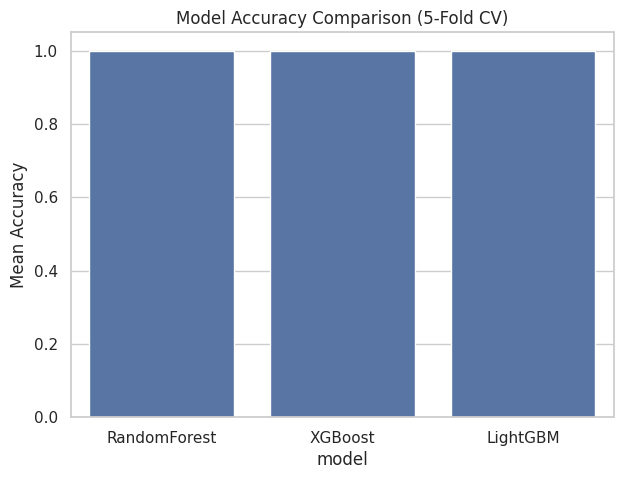

In [28]:
# ---------------------------
# CELL 6 - Model Comparison
# ---------------------------
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.1,
        eval_metric='mlogloss', n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=400, learning_rate=0.1, random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, clf in models.items():
    print(f"Evaluating {name} ...")
    scores = cross_val_score(clf, X_train, y_train, cv=skf,
                             scoring='accuracy', n_jobs=-1)
    results.append({'model': name,
                    'mean_acc': scores.mean(),
                    'std_acc': scores.std()})

res_df = pd.DataFrame(results).sort_values('mean_acc', ascending=False)
print('\nModel Comparison:')
display(res_df)

plt.figure(figsize=(7,5))
sns.barplot(data=res_df, x='model', y='mean_acc')
plt.title('Model Accuracy Comparison (5-Fold CV)')
plt.ylabel('Mean Accuracy')
plt.show()

In [29]:
# ---------------------------
# CELL 7 - Train Best Model
# ---------------------------
best_name = res_df.iloc[0]['model']
best_clf = models[best_name]
best_clf.fit(X_train, y_train)

os.makedirs('models', exist_ok=True)
joblib.dump({'vectorizer': vectorizer, 'label_encoder': le, 'model': best_clf},
            f'models/best_model_{best_name}.joblib')

print(f"✅ Best Model Trained and Saved: {best_name}")

✅ Best Model Trained and Saved: RandomForest


Test Accuracy: 1.0

Classification Report:
                     precision    recall  f1-score   support

 Fertilizer Sprayer       1.00      1.00      1.00        47
       Field Worker       1.00      1.00      1.00        44
 Harvester Operator       1.00      1.00      1.00        47
    Plough Operator       1.00      1.00      1.00        44
    Seeder Operator       1.00      1.00      1.00        48
  Thresher Operator       1.00      1.00      1.00        35
   Tractor Operator       1.00      1.00      1.00        39
 Transport Labourer       1.00      1.00      1.00        45
Water Pump Operator       1.00      1.00      1.00        51

           accuracy                           1.00       400
          macro avg       1.00      1.00      1.00       400
       weighted avg       1.00      1.00      1.00       400



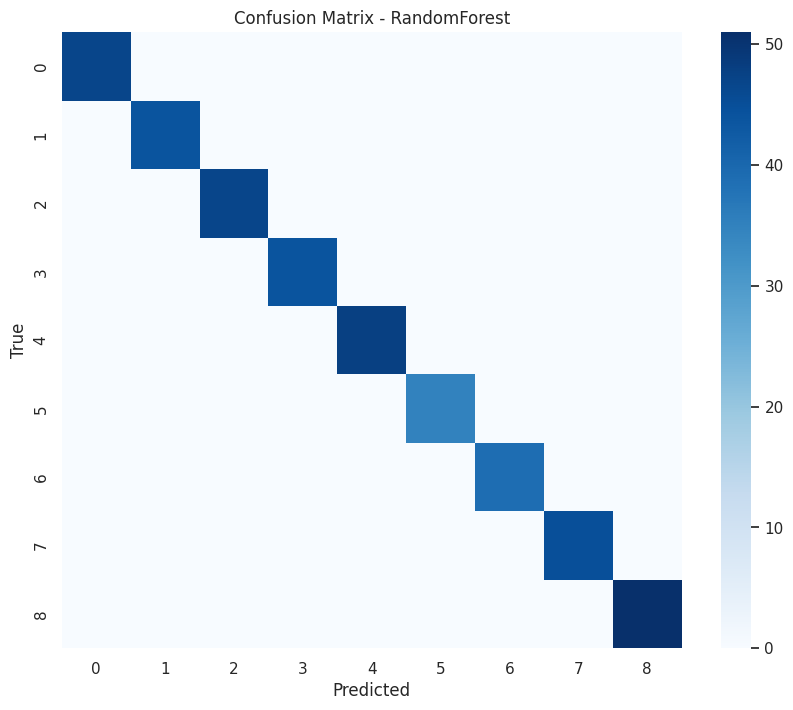

,Class,Accuracy
0,Fertilizer Sprayer,1.0
1,Field Worker,1.0
2,Harvester Operator,1.0
3,Plough Operator,1.0
4,Seeder Operator,1.0
5,Thresher Operator,1.0
6,Tractor Operator,1.0
7,Transport Labourer,1.0
8,Water Pump Operator,1.0


In [30]:
# ---------------------------
# CELL 8 - Evaluate Model
# ---------------------------
y_pred = best_clf.predict(X_test)

print('Test Accuracy:', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# Per-Class Accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
acc_table = pd.DataFrame({'Class': le.classes_, 'Accuracy': per_class_acc})
display(acc_table.sort_values('Accuracy', ascending=False).head(10))

In [31]:
# ---------------------------
# CELL 9 - 100% ML Query Recommendation (Semantic + Classifier)
# ---------------------------
from sentence_transformers import SentenceTransformer, util
model_semantic = SentenceTransformer('all-MiniLM-L6-v2')

# Precompute embeddings for all labours (once)
DF['text_for_embed'] = DF['combined_text'] + ' ' + DF['Labour_Type']
DF['embedding'] = DF['text_for_embed'].apply(lambda x: model_semantic.encode(x, convert_to_tensor=True))

def recommend_for_query(query, top_k=5):
    obj = joblib.load(f'models/best_model_{best_name}.joblib')
    vec, lbl, mdl = obj['vectorizer'], obj['label_encoder'], obj['model']

    # Predict labour type
    qv = vec.transform([query])
    pred = mdl.predict(qv)[0]
    pred_label = lbl.inverse_transform([pred])[0]

    # Compute query embedding
    query_emb = model_semantic.encode(query, convert_to_tensor=True)

    # Filter by predicted label first
    filtered = DF[DF['Labour_Type_collapsed'] == pred_label].copy()

    # Compute semantic similarity
    filtered['similarity'] = filtered['embedding'].apply(lambda x: util.cos_sim(query_emb, x).item())

    # Apply optional rate filters
    m = re.search(r'(under|below|less than|more than|above)\s*(\d+)', query.lower())
    if m:
        direction, val = m.groups()
        val = float(val)
        if direction in ['under','below','less than']:
            filtered = filtered[filtered['Hourly_Rate'] <= val]
        else:
            filtered = filtered[filtered['Hourly_Rate'] >= val]

    # Final ranking by similarity + rating
    filtered['score'] = 0.7*filtered['similarity'] + 0.3*(filtered['Rating']/5.0)
    top_matches = filtered.sort_values(by='score', ascending=False).head(top_k)

    print("Predicted Labour Type:", pred_label)
    display(top_matches[['Name','Location','Labour_Type','Season','Crop_Type','Hourly_Rate','Rating','similarity','score']])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [32]:
# ---------------------------
# CELL 10 - Test Queries
# ---------------------------
q1 = "I need a tractor for ploughing Hourly Rate less than 2000"
recommend_for_query(q1, top_k=5)

q2 = "Find an experienced harvester for rice during Yala season"
recommend_for_query(q2, top_k=5)

q3 = "Looking for a water pump operator for maize farm under 1000"
recommend_for_query(q3, top_k=5)

Predicted Labour Type: Tractor Operator


,Name,Location,Labour_Type,Season,Crop_Type,Hourly_Rate,Rating,similarity,score
367,Kamal Bandara,"Alawwa, Kurunegala",Tractor Operator,Maha,Vegetable,1439.0,5.0,0.532967,0.673077
1269,Kamal Bandara,"Alawwa, Kurunegala",Tractor Operator,Maha,Vegetable,1439.0,5.0,0.532967,0.673077
1525,Isuru Wijesinghe,"Narammala, Kurunegala",Tractor Operator,Maha,Vegetable,1321.0,5.0,0.513757,0.659630
623,Isuru Wijesinghe,"Narammala, Kurunegala",Tractor Operator,Maha,Vegetable,1321.0,5.0,0.513757,0.659630
604,Lakshan Wickramasinghe,"Pothuhera, Kurunegala",Tractor Operator,Maha,Vegetable,1182.0,5.0,0.512780,0.658946


Predicted Labour Type: Harvester Operator


,Name,Location,Labour_Type,Season,Crop_Type,Hourly_Rate,Rating,similarity,score
659,Sunil Abeysinghe,"Narammala, Kurunegala",Harvester Operator,Yala,Rice,1239.0,5.0,0.734059,0.813841
1561,Sunil Abeysinghe,"Narammala, Kurunegala",Harvester Operator,Yala,Rice,1239.0,5.0,0.734059,0.813841
512,Pubudu Rajapaksha,"Narammala, Kurunegala",Harvester Operator,Yala,Rice,1272.0,5.0,0.730340,0.811238
1414,Pubudu Rajapaksha,"Narammala, Kurunegala",Harvester Operator,Yala,Rice,1272.0,5.0,0.730340,0.811238
447,Gayan Rajapaksha,"Narammala, Kurunegala",Harvester Operator,Yala,Rice,1597.0,4.9,0.734059,0.807841


Predicted Labour Type: Water Pump Operator


,Name,Location,Labour_Type,Season,Crop_Type,Hourly_Rate,Rating,similarity,score
175,Sampath Wickramasinghe,"Pothuhera, Kurunegala",Water Pump Operator,Maha,Vegetable,916.0,4.9,0.670617,0.763432
1077,Sampath Wickramasinghe,"Pothuhera, Kurunegala",Water Pump Operator,Maha,Vegetable,916.0,4.9,0.670617,0.763432
1979,Sampath Wickramasinghe,"Pothuhera, Kurunegala",Water Pump Operator,Maha,Vegetable,916.0,4.9,0.670617,0.763432
1434,Ishara Silva,"Alawwa, Kurunegala",Water Pump Operator,Yala,Vegetable,943.0,4.8,0.660159,0.750112
532,Ishara Silva,"Alawwa, Kurunegala",Water Pump Operator,Yala,Vegetable,943.0,4.8,0.660159,0.750112


In [36]:
# ---------------------------
# CELL 10 - Test Queries
# ---------------------------
q1 = "Find me a skilled transport for  farms under 1500 per hour"
recommend_for_query(q1, top_k=5)

Predicted Labour Type: Transport Labourer


,Name,Location,Labour_Type,Season,Crop_Type,Hourly_Rate,Rating,similarity,score
499,Sajith Dias,"Wariyapola, Kurunegala",Transport Labourer,Maha,Rice,1273.0,4.8,0.457630,0.608341
1401,Sajith Dias,"Wariyapola, Kurunegala",Transport Labourer,Maha,Rice,1273.0,4.8,0.457630,0.608341
787,Nadeesha Silva,"Wariyapola, Kurunegala",Transport Labourer,Maha,Vegetable,1363.0,4.7,0.452761,0.598933
1689,Nadeesha Silva,"Wariyapola, Kurunegala",Transport Labourer,Maha,Vegetable,1363.0,4.7,0.452761,0.598933
1384,Kavindi Fernando,"Wariyapola, Kurunegala",Transport Labourer,Maha,Vegetable,1411.0,4.8,0.433085,0.591160
